# Asset-based lending: "a primer in python"<br>
>## <font color = green>Asset_based lending (ABL) is an efficient and flexible technique to finance working capital, especially for leveraged businesses that need to manage cash.  It works quite well for noninvestment grade manufacturers and distributors that want to finance the growth of inventories and accounts.  In this notebook I've written a simple ABL platform in python to illustrate ABL's capabilities.
</font>

>__[ABL from Wikipedia](https://en.wikipedia.org/wiki/Asset-based_lending)__




>## <font color = 'blue'>Managing cash drives ABL. For simplicity sake we are only using accounts receivable as collateral.  Here are a few critical points to understand about our model:
>*  The model tracks three primary cash flows:
    * <b>Presentments.</b>The line of credit funds checks presented for payment, outgoing wires and ACH transfers out.  In our model the method loan.draw(presentments) is used to fund cash outflows and results in a increase on the line of credit.
    * <b>Cash collections</b>.  The function, sales_collections(collateral_object, loan_object, collections) takes cash collections and uses it to reduce the loan balance and the accounts receivable.
    * <b>New Sales</b>.  The method collateral_object.new_sales(sales) increase the accounts receivable
*  The model also tracks two stock accounts:
    * <b>Loan account.</b>  The loan consisting of the commited facility and the loan balance.  
    * <b>Collateral account.</b>  The total amount of accounts receivable.
* Lastly and most importantly the model provides a tool for company management and lending risk officers to monitor and track liquidity
    * <b>Availability.</b>  Calculates the maximun loan value of the collateral.  The class method Accounts_receivable.loan_availability calculates the loan value of the collateral
    * <b>Excess Availability.</b>  The function excess_availability(collateral_object, loan_object) nets the value of the collateral against the outstanding loan with the difference being excess availability.  Almost every method and function in our model impacts this number</>


### Step one.  import our dependencies

In [1]:
from datetime import date
import pandas as pd
import matplotlib.pyplot as plt
import random


In [2]:
from loan_sys_objects import Customer, Loan, Accounts_receivable, Interest
from loan_sys_functions import excess_availability, sales_collections, fund_presentments, daily_build, interest_settlement
from loan_sys_functions import loan_hist, date_hist_str, i_rate_hist, accrued_interest_hist, liquidity_hist

### Step two.  Create an instance of the following:
* Customer object
* Loan object
* Accounts_receivable object
* Interest object


In [3]:
ABC_mfg = Customer('ABC_mfg', 'abc@gmail.com', 'Atlanta')
ABC_loan = Loan(5000000, 0)
ABC_collateral = Accounts_receivable(6000000, 600000, .85)
ABC_interest = Interest(.03, .0325)

#### Verify the customer object:

In [4]:
ABC_mfg

Customer name: ABC_mfg
Customer email: abc@gmail.com
Customer Location: Atlanta 

#### Verify the loan object:

In [5]:
ABC_loan

Commitment:$5,000,000
Loan: $0

#### Verify the collateral object:

In [6]:
ABC_collateral

Total Aging:$6,000,000
Past Dues: $600,000
Advance Rate: 85.00%

#### Verify the interest object

In [7]:
ABC_interest

Base Rate:3.00%
Margin: 3.25%

In [8]:
f'The interest rate is the sum of the base rate plus the margin: {ABC_interest.interest_rate():.2%}'

'The interest rate is the sum of the base rate plus the margin: 6.25%'

### <font color = green > To summarize:
* ABC mfg has a commited credit facility secured by the company's accounts receivable.  The initial loan balance is $0.
* ABC mfg has pledged 6,000,000 of accounts to the lender but the lender but determined that past due accounts are 600,000 and will lend 85 percent of the eligible accounts.
* The interest rate consists of two parts, a base rate and a margin.  The base rate is typically tied to an index such as 90 libor, US prime rate or some similar market rate.  The number is variable, that is it can fluctuate with the market.  The lenders margin is 3.25 percent above the index.  This percentage is contractually fixed.</font>



> #### An important concept is the term "availability".  For many borrowers excess availability is synonomous with liquidity

In [9]:
collateral_availability = ABC_collateral.loan_availability()
f'Collateral Availability totals ${collateral_availability:,.2f}.  This equates to gross acounts minus past dues and subsequently reduced by the advance rate of 85%'

'Collateral Availability totals $4,590,000.00.  This equates to gross acounts minus past dues and subsequently reduced by the advance rate of 85%'

In [10]:
excess_avail = excess_availability(ABC_collateral, ABC_loan)
f'Excess Availability totals ${excess_avail:,.2f}.  Excess availability equates to collateral availability less the loan balance'

'Excess Availability totals $4,590,000.00.  Excess availability equates to collateral availability less the loan balance'

### So far, excess Availability is the same as total Availability that's true because the borrower has a zero loan balance.  Lets borrow some money and see what happens

#### We will call the loan_draw method on the loan object to make a $50,000 loan advance

In [11]:
f"The borrower draws down $50,000 and the new loan balance is ${ABC_loan.loan_draw(50000):,.2f}"

'The borrower draws down $50,000 and the new loan balance is $50,000.00'

In [12]:
f" After the draw the excess availability has dropped $50,000 to ${excess_availability(ABC_collateral, ABC_loan):,.2f}"

' After the draw the excess availability has dropped $50,000 to $4,540,000.00'

In [13]:
ABC_loan

Commitment:$5,000,000
Loan: $50,000

In [14]:
ABC_collateral

Total Aging:$6,000,000
Past Dues: $600,000
Advance Rate: 85.00%

#### Next the borrower collects $10,000 of accounts.  We apply the collections to reduce the loan balance and to reduce the collateral balance

In [15]:
sales_collections(ABC_collateral, ABC_loan, 10000)

In [16]:
f"The new loan amount is ${ABC_loan.loan:,.2f}" 

'The new loan amount is $40,000.00'

In [17]:
f"The new excess availability is ${excess_availability(ABC_collateral, ABC_loan):,.2f}"

'The new excess availability is $4,541,500.00'

#### Let's recap:

In [18]:
ABC_loan

Commitment:$5,000,000
Loan: $40,000

In [19]:
ABC_collateral

Total Aging:$5,990,000
Past Dues: $600,000
Advance Rate: 85.00%

In [20]:
excess_avail = excess_availability(ABC_collateral, ABC_loan)
f'Excess Availability totals ${excess_avail:,.2f}.'

'Excess Availability totals $4,541,500.00.'

> ### <font color = 'green'> Once again to summarize:
* The borrower opened with no loan and 4,590,000 in excess undrawn availability on the line of credit.
* The borrower then took a draw for 50,000.  The loan went up and excess availability went down, both by 50,000
* Next the borrower collected 10,000 of accounts receivable. The loan decreases by 10,000 and the collateral decreases by $10,000 but the excess availability, the liquidity of the business increases by 1,500.  This is an important point.  Borrowers are rewarded for collecting cash and paying down their lon by generating additional excess availability.  The EA increases by the reciprocal of the advance rate (15 percent), thus the 1,500.

In [21]:
fund_presentments(ABC_collateral, ABC_loan, 1000),ABC_collateral.new_sales(1500)

(None, 5991500)

In [22]:
# ABC_collateral.new_sales(1500) 
ABC_collateral

Total Aging:$5,991,500
Past Dues: $600,000
Advance Rate: 85.00%

In [23]:
fund_presentments(ABC_collateral, ABC_loan, 10000000)

Your advance of $10,000,000.00 exceeds your excess_availability of $4,541,775.00:  ADVANCE REJECTED!


In [24]:
ABC_loan.commitment

5000000

In [25]:
ABC_loan.loan

41000

In [26]:
ABC_loan

Commitment:$5,000,000
Loan: $41,000

In [27]:
excess_availability(ABC_collateral, ABC_loan)

4541775.0

In [28]:
fund_presentments(ABC_collateral, ABC_loan, 225)

In [29]:
ABC_loan

Commitment:$5,000,000
Loan: $41,225

In [30]:
fund_presentments(ABC_collateral, ABC_loan, 1225000)

In [31]:
ABC_loan

Commitment:$5,000,000
Loan: $1,266,225

In [32]:
fund_presentments(ABC_collateral, ABC_loan, 5000000)

Your advance of $5,000,000.00 exceeds your excess_availability of $3,316,550.00:  ADVANCE REJECTED!


In [33]:
ABC_collateral.new_sales(5000000)

10991500

In [34]:
fund_presentments(ABC_collateral, ABC_loan, 5000000)

ADVANCE REJECTED: Borrower may not exceed the loan commitment of $5,000,000.00


>## <font color = 'blue'> The next step is to simulate a month's worth of activity and track our borrower.
* We create a for loop that generates a month's wortth of daily presentments, sales, and collections.  We randomize a daily growth rate of between 0% and 5%.
* Next we create a pandas DataFrame to display the activity.
* Finally we plot the data.

In [35]:
new_co = Customer('New_Company', 'new@mail', 'roswell')
new_loan = Loan(5000000, 1000000)
new_collateral = Accounts_receivable(6000000, 600000, .85)
new_interest = Interest(.03, .035)

presentments = 125000
sales = 100000
collections = 80000
day = 1

for i in range(31):
    presentments *= random.uniform(1.0, 1.05)
    collections *= random.uniform(1.0, 1.05)
    sales *= random.uniform(1.0, 1.05)

    sales_collections(new_collateral, new_loan, int(collections))
    fund_presentments(new_collateral, new_loan, int(presentments))
    new_collateral.new_sales(int(sales))
    daily_build(2019, 3, day, new_loan, new_interest, new_collateral)
    
    day += 1
    

In [36]:
df = pd.DataFrame(
    {
     'Date': date_hist_str,
     'Loan': loan_hist,
     'Excess Availability': liquidity_hist,  
     'Interest Rate': i_rate_hist,
     'Interest Accrual': accrued_interest_hist,
    })
df = df[["Date", "Loan", "Excess Availability", "Interest Rate", "Interest Accrual"]]
df.set_index('Date', inplace=True)
df['Cumulative Interest'] = df['Interest Accrual'].cumsum()

In [37]:
df

,Loan,Excess Availability,Interest Rate,Interest Accrual,Cumulative Interest
Date,,,,,
2019-03-01,1046378,3561493.25,0.065,188.929361,188.929361
2019-03-02,1094801,3532262.40,0.065,197.672403,386.601764
2019-03-03,1148162,3500627.40,0.065,207.307028,593.908792
2019-03-04,1204769,3463442.90,0.065,217.527736,811.436528
2019-03-05,1262685,3424990.20,0.065,227.984792,1039.421319
2019-03-06,1320926,3384378.20,0.065,238.500528,1277.921847
2019-03-07,1379995,3340679.75,0.065,249.165764,1527.087611
2019-03-08,1440201,3294449.45,0.065,260.036292,1787.123903
2019-03-09,1504600,3245698.10,0.065,271.663889,2058.787792


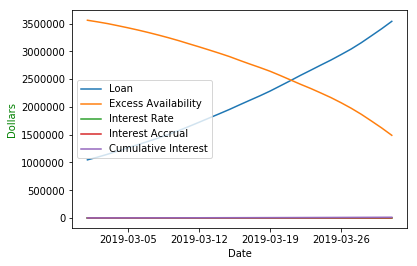

In [38]:
%matplotlib inline
plt.figure()
df.plot()
plt.legend(loc='best')
plt.ylabel('Dollars', color='g')
plt.show()

### Next step is to calculate the interest cost.  Below we calculate the loan balance before the interest settlement.  Then calculate the loan balance after the interest settlement calculation.  The difference in the loan balance is the interest charge for the month.  Note this should foot with the last number of the cumulative interest data series in the data frame.

In [39]:
new_loan.loan

3541766

In [40]:
interest_settlement(2019, 3, 1, 2019, 3, 31, new_loan)

In [41]:
new_loan.loan

3553623.0979583333

### Last step is to reset the data so that we can run a notebook using fresh data.

In [43]:
loan_hist.clear(), date_hist_str.clear(), i_rate_hist.clear(), accrued_interest_hist.clear(), liquidity_hist.clear()

(None, None, None, None, None)